# InceptionNet
Taking into account smart usage of Convolutions and wishing to improve quality of feature extraction with "mixed" kernels research team from Google proposed GoogLeNet and InceptionNet architecture.

## Part I. Quick Overview & Goal Setting.
This network architecture is way more interesting.<br>
I don't expect something crazy here again, because gradient vanishment was only partially fixed in this architecture.<br>
Graph you see below is an example of Inception network architecture.<br>

<img src="https://miro.medium.com/v2/resize:fit:3968/1*G9ir2O2wEcSZtglhcWsnNA.png" width=100%><br>
The name of the architecture links to the "We need to go deeper" meme.<br>
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQM6i47xzNeGrrXKESzHhYSfv9-hdwr9DmtfQ&s" width=30%><br>
And well... For a reason, because InceptionNet is built of "layers" that store layers and calculates multiple auxilary outputs to resolve gradient vanishment.<br>
This architecture applies multiple kernels at once stacking outputs.<br>
But authors didn't stop here. They optimized network (as Google planned to use in production)<br>
## Data.
I will use ImageNet100 again and... I think I'll regret it.

In [1]:
!pip install torchmetrics
!pip install torchinfo

In [2]:
import torch
from torch import nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, ConcatDataset
from torch.utils.tensorboard import SummaryWriter

from torchmetrics import Accuracy
from torchinfo import summary
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import os

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
root_dir = Path("/kaggle/input/imagenet100")

In [5]:
data_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.RandomCrop(size=(224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
part_0 = ImageFolder(root_dir / "train.X1", transform=data_transform)
part_1 = ImageFolder(root_dir / "train.X2", transform=data_transform)
part_2 = ImageFolder(root_dir / "train.X3", transform=data_transform)
part_3 = ImageFolder(root_dir / "train.X4", transform=data_transform)

train_dataset = ConcatDataset([part_0, part_1, part_2, part_3])
test_dataset = ImageFolder(root_dir / "val.X", transform=data_transform)

In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,
                              num_workers=os.cpu_count())

test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                             num_workers=os.cpu_count())

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7bdf6e395210>,
 <torch.utils.data.dataloader.DataLoader at 0x7bdf6ee78610>)

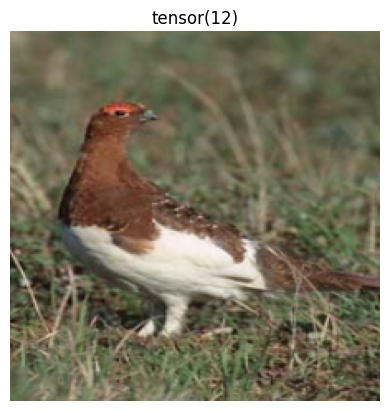

In [8]:
for image_batch, label_batch in train_dataloader:
    image = image_batch[0]
    label = label_batch[0]

    plt.title(label)
    plt.axis("off")
    plt.imshow(image.permute(1, 2, 0));
    break

## Part III. Model
Now I'll use different implementation style, because custom parts (inception blocks) are used

### Inception Block.
<img src="https://miro.medium.com/v2/resize:fit:1232/1*H_ZYfZ52t6M4UmML6a6pAQ.png" width=30%>

In [14]:
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU()
        # 1st block part
        self.bp1 = nn.Sequential(nn.Conv2d(in_channels, out_channels[0], kernel_size=1, padding=0, stride=1), self.relu)
        # 2nd block part
        self.bp2 = nn.Sequential(nn.Conv2d(in_channels, out_channels[1], kernel_size=1, padding=0, stride=1), self.relu,
                                 nn.Conv2d(out_channels[1], out_channels[2], kernel_size=3, padding=1, stride=1), self.relu)
        # 3rd block part
        self.bp3 = nn.Sequential(nn.Conv2d(in_channels, out_channels[3], kernel_size=1, padding=0, stride=1), self.relu,
                                 nn.Conv2d(out_channels[3], out_channels[4], kernel_size=5, padding=2, stride=1), self.relu)
        # 4th block part
        self.bp4 = nn.Sequential(nn.MaxPool2d(kernel_size=3, padding=1, stride=1), nn.Conv2d(in_channels, out_channels[5], kernel_size=1, padding=0, stride=1))

    def forward(self, x):
        out1 = self.bp1(x)
        out2 = self.bp2(x)
        out3 = self.bp3(x)
        out4 = self.bp4(x)

        return torch.cat((out1,out2,out3,out4), axis=1)  # concatenate channels axis (batch, channels, w, h)

In [15]:
class AuxClassifier(nn.Module):
    def __init__(self, in_channels, classes):
        super().__init__()
        in_features = 4 * 4 * 128
        self.avg_pool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv1x1 = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=1, stride=1, padding=0)
        self.fc1 = nn.Linear(in_features=in_features, out_features=in_features)
        self.fc2 = nn.Linear(in_features=in_features, out_features=classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.7)
    
    def forward(self, x):
        x = self.avg_pool(x)
        x = self.relu(self.conv1x1(x))
        x = torch.flatten(x, 1)
        x = self.relu(self.dropout(self.fc1(x)))
        x = self.fc2(x)
        return x

In [26]:
class GoogLeNet(nn.Module): 
    def __init__(self, in_depth=3, classes=1000):
        super().__init__()

        in_channels = [192, 256, 480, 512, 512, 512, 528, 832, 832, 1024]
        feature_maps = [[64, 96, 128, 16, 32, 32],
                        [128, 128, 192, 32, 96, 64],
                        [192, 96, 208, 16, 48, 64],
                        [160, 112, 224, 24, 64, 64],
                        [128, 128, 256, 24, 64, 64],
                        [112, 144, 288, 32, 64, 64],
                        [256, 160, 320, 32, 128, 128],
                        [256, 160, 320, 32, 128, 128],
                        [384, 192, 384, 48, 128, 128]
                    ]
    
        self.AuxClass1 = AuxClassifier(512, classes)
        self.AuxClass2 = AuxClassifier(528,classes)
        self.Blocks = nn.ModuleList([InceptionBlock(in_channels[i], feature_maps[i]) for i in range(len(feature_maps))])
        
        # Rest of the model
        self.Conv7k = nn.Conv2d(in_channels=in_depth, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.Conv1k = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.Conv3k = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, stride=1, padding=1)
        self.MaxPool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.LocalNorm = nn.LocalResponseNorm(size=5)
        self.AvgPool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.FC = nn.Linear(1024, classes)
        self.Dropout = nn.Dropout(0.4)
        self.relu = nn.ReLU()

    def forward(self, x):
        outputs = []
        # x shape : [batch, 3, 224, 224]
        x = self.relu(self.Conv7k(x))
        x = self.LocalNorm(self.MaxPool(x))
        x = self.relu(self.Conv1k(x))
        x = self.LocalNorm(self.relu(self.Conv3k(x)))
        x = self.MaxPool(x)
        for i, block in enumerate(self.Blocks):
            if i == 2 or i==7:
                x = self.MaxPool(x)
            elif i == 3:
                outputs.append(self.AuxClass1(x))
            elif i == 6:
                outputs.append(self.AuxClass2(x))

            x = block(x)
        
        x = self.Dropout(self.AvgPool(x))
        x = torch.flatten(x,1)
        x = self.FC(x)
        outputs.append(x)
        return outputs[-1]

In [32]:
inception = GoogLeNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=inception.parameters())

In [33]:
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    accuracy_fn = Accuracy("multiclass", num_classes=100).to(device)
    running_loss, running_acc = 0, 0

    model.train()
    
    for image_batch, label_batch in dataloader:
        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)

        logits = model(image_batch)
        activated_pred = torch.softmax(logits, dim=1).argmax(dim=1)

        batch_accuracy = accuracy_fn(activated_pred, label_batch)
        batch_loss = loss_fn(logits, label_batch)
        running_loss += batch_loss
        running_acc += batch_accuracy

        optimizer.zero_grad()
        batch_loss.backward()
        nn.utils.clip_grad_norm_(inception.parameters(), max_norm=10)
        optimizer.step()

    running_loss /= len(dataloader)
    running_acc /= len(dataloader)

    return running_loss, running_acc


def test_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              device: torch.device):
    accuracy_fn = Accuracy("multiclass", num_classes=100).to(device)
    running_loss, running_acc = 0, 0

    model.eval()
    
    with torch.inference_mode():
        for image_batch, label_batch in dataloader:
            image_batch = image_batch.to(device)
            label_batch = label_batch.to(device)
    
            logits = model(image_batch)
            activated_pred = torch.softmax(logits, dim=1).argmax(dim=1)
    
            batch_accuracy = accuracy_fn(activated_pred, label_batch)
            batch_loss = loss_fn(logits, label_batch)
            running_loss += batch_loss
            running_acc += batch_accuracy
    
        running_loss /= len(dataloader)
        running_acc /= len(dataloader)
    return running_loss, running_acc

In [ ]:
EPOCHS = 20
torch.manual_seed(42)
torch.cuda.manual_seed(42)


results = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

writer = SummaryWriter()

for epoch in range(EPOCHS):
    train_loss, train_acc = train_step(inception, train_dataloader, loss_fn, optimizer, device)
    test_loss, test_acc = test_step(inception, test_dataloader, loss_fn, device)

    print(f"EPOCH: {epoch} | "
          f"tr_loss: {train_loss} | tr_acc: {train_acc}"
          f"ts_loss: {test_loss} | ts_acc: {test_acc}"
         )

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/test', test_loss, epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('Accuracy/test', test_acc, epoch)